In [ ]:
# https://rstudio-pubs-static.s3.amazonaws.com/407929_afc5ef0f2ad648389447a6ca3f4a7cd4.html
# https://data.gov.ie/dataset/electoral-districts-boundaries-generalised-to-50m-osi-national-statutory-boundaries/resource/c77a5b01-fef7-4d4f-8660-b36808a15ce7

In [273]:
# ! pip install sklearn

In [9]:
import pandas as pd
import numpy as np
import csv
# from sklearn import preprocessing

In [7]:
# %cd ../../data/airbnbdata/geo
!ls

201702_neighbourhoods.geojson	    cso.csv		    shapefiles
Electoral_Districts_Boundaries.csv  neighbourhoods.geojson


In [11]:
filename = 'cso.csv'

df = pd.read_csv(filename,
                       encoding='latin1',
#                        compression='gzip',
                       sep=',',
#                        index_col = 0,
                       header=0
                       )

# reshape data
df.columns
df.rename(columns={' ': 'house_type',
                  ' .1': 'rooms',
                  ' .2': 'location'}, inplace=True)
df.replace(' ', np.NaN, inplace=True)
df.fillna(method='ffill', inplace=True)
df.dropna(inplace=True)

# Dublin only
df = df[df['location'].str.contains("Dublin")]

df['town'], df['county'] = df['location'].str.split(', ').str
df['county'] = df.apply(
    lambda row: 'County ' + row['town'].split(' ')[0] if  pd.isnull(row['county']) else row['county'],
    axis=1
)
df.head()
# df.location.unique()
# # df.isnull().any().any()
# df.town.unique()
# df.county.unique()
df.rooms.unique()
# df[df.town=='Dublin'].head()
# df[df.County=='Dublin'].head()
# df[df.County.isnull()].head()
# df[df['location'].str.contains("I.F.S.C")].head()
df.head()
# df.columns

,house_type,rooms,location,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,town,county
73,Detached house,One bed,Dublin,0.0,0.0,0.0,942.74,850.6,781.93,827.24,919.74,1009.05,1098.09,Dublin,County Dublin
74,Detached house,One bed,"Balbriggan, Dublin",0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,Balbriggan,Dublin
75,Detached house,One bed,"Blackrock, Dublin",0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,Blackrock,Dublin
76,Detached house,One bed,"Booterstown, Dublin",0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,Booterstown,Dublin
77,Detached house,One bed,"Cabinteely, Dublin",0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,Cabinteely,Dublin


#### Melt

In [12]:
df2 = df.copy()
df2.drop('location', axis=1, inplace=True)
df2 = pd.melt(df2,id_vars=['house_type', 'rooms', 'town', 'county'],
               var_name='year',
               value_name='rent'
             )
df2 = df2.sort_values(by=["house_type"])
# df2[df2['rent'].apply(lambda x: isinstance(x, str))] # check whether there is a String in the columns
# df2.isnull().any().any()
df2.rent.describe()
df2.head()


,house_type,rooms,town,county,year,rent
35069,All property types,All bedrooms,Tallaght,Dublin 24,2012,893.04
33904,All property types,One bed,Booterstown,Dublin,2012,0.00
33903,All property types,One bed,Blackrock,Dublin,2012,900.34
33902,All property types,One bed,Balbriggan,Dublin,2012,570.63
33901,All property types,One bed,Dublin,County Dublin,2012,766.46


#### Group By

In [280]:
df3 = df2.copy()
df3 = df3[(df3.year=='2017') & (df3.rent!=0.0)]
(df3.groupby(['house_type', 'rooms', 'town', 'county'])
.agg({'rent': np.median})
# .sort_values(by='rent', ascending=False)
).head()

rent
house_type         rooms      town           county            
All property types 1 to 2 bed Arbour Hill    Dublin 7   1259.86
                              Artane         Dublin 5   1208.38
                              Ashtown        Dublin 15  1297.92
                              Aungier Street Dublin 2   1405.00
                              Balbriggan     Dublin      956.57

#### Normalize

In [303]:
min_max_scaler = preprocessing.MinMaxScaler()

df = df3.copy()
df.rent = min_max_scaler.fit_transform(df[['rent']])
df.head()

,house_type,rooms,town,county,year,rent
70138,All property types,All bedrooms,Firhouse,Dublin 24,2017,0.308005
69705,All property types,1 to 3 bed,Dartry,Dublin 6,2017,0.364460
69704,All property types,1 to 3 bed,Dublin 6,County Dublin,2017,0.268355
69703,All property types,1 to 3 bed,Raheny,Dublin 5,2017,0.346995
69702,All property types,1 to 3 bed,Killester,Dublin 5,2017,0.297181


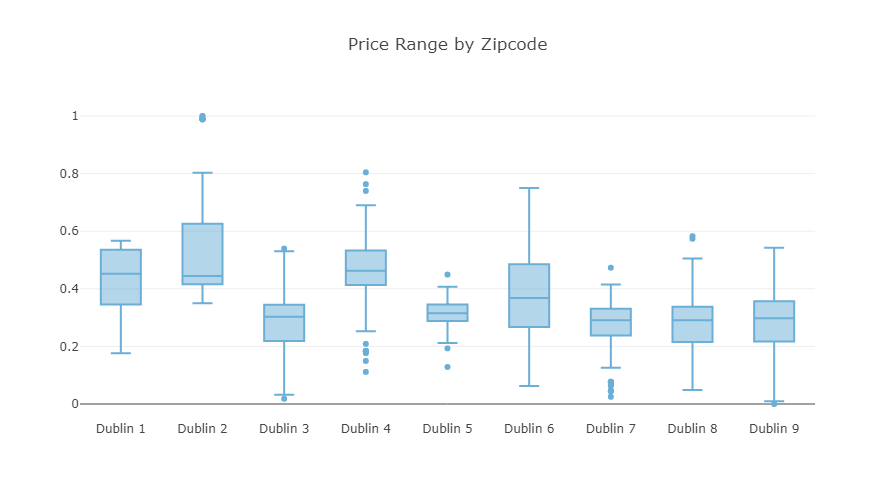

In [304]:
layout = go.Layout(
    title = 'Price Range by Zipcode',
    autosize=False,
    width=500,
    height=500,
    showlegend=False)
traces = []

# zipcode subset
zipcodes = (['Dublin 1', 'Dublin 2', 'Dublin 3', 'Dublin 4', 
            'Dublin 5', 'Dublin 6', 'Dublin 7', 'Dublin 8', 
            'Dublin 9'])
df = df[df.county.isin(zipcodes)]

for z in sorted(df.county.unique().tolist()):
    df_aux = df[df.county==z]
    y = df_aux.rent
    traces.append(go.Box(y=y,
                         name=z,
                         boxpoints = 'outliers',
                         marker = dict(color = 'rgb(107,174,214)'),
                         line = dict(color = 'rgb(107,174,214)')
                        ))
                  
data = traces
fig = go.Figure(data=data,layout=layout)
offline.iplot(fig)

### Timeseries

#### Multi-Index

In [336]:
df_time = df2.copy()
df_time.set_index(['house_type', 'rooms', 'county', 'town']
                  , inplace=True)
df_time.sort_index(inplace=True)
df_time.head()

year     rent
house_type         rooms      county        town                 
All property types 1 to 2 bed County Dublin Dublin  2011   915.82
                                            Dublin  2013   952.06
                                            Dublin  2012   929.68
                                            Dublin  2009  1080.72
                                            Dublin  2010   948.87

#### GroupBy

In [375]:
grouped = (df_time.groupby(['house_type', 'rooms', 'county', 'town', 'year'])
          .agg({'rent': np.median})
          .reset_index()
          )
print(len(grouped))
grouped['test'] = grouped['house_type'] + grouped['rooms'] + grouped['county'] + grouped['town']
grouped.sort_values(by='year').head()


70140


,house_type,rooms,county,town,year,rent
0,All property types,1 to 2 bed,County Dublin,Dublin,2008,1197.99
34480,Detached house,Two bed,Dublin 2,Townsend Street,2008,0.00
34490,Detached house,Two bed,Dublin 20,Chapelizod,2008,0.00
34500,Detached house,Two bed,Dublin 20,Palmerstown,2008,0.00
7230,All property types,One bed,Dublin 11,Ballymun,2008,933.16


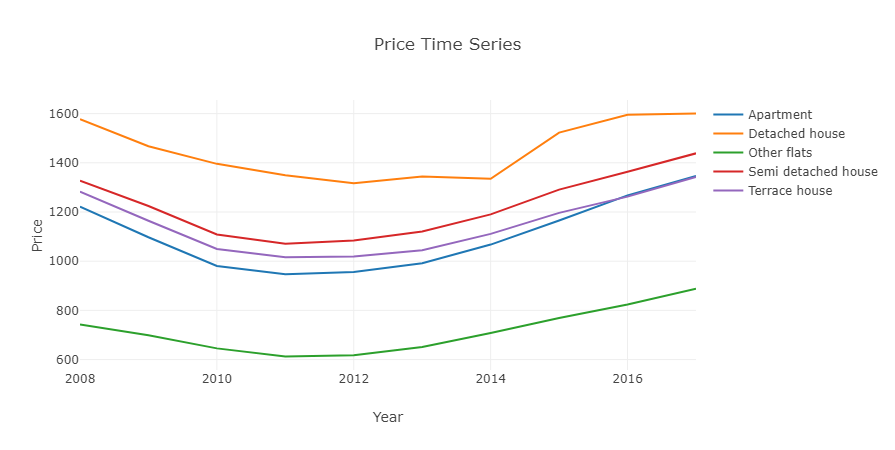

In [429]:
df = df2.copy()
df = df[(df.rent!=0.0) & (df.house_type!='All property types')]
traces = []
years = sorted(df.year.unique().tolist())
# print(years)
for z in sorted(df.house_type.unique().tolist()):
    df_aux = df[df.house_type==z]
    grouped = (df_aux.groupby(['house_type', 'year'])
               .agg({'rent': np.median})
              )

    traces.append(go.Scatter(x=years,
                         y=grouped.rent.values,
                         name=z,
                         mode = 'lines',
                        ))
#     break                   


layout = go.Layout(
    title = 'Price Time Series',
    autosize=True,
    showlegend=True,
    xaxis = dict(title = 'Year'),
    yaxis = dict(title = 'Price'),)

# Edit the layout
# layout = dict(title = 'Average High and Low Temperatures in New York',
#               xaxis = dict(title = 'Month'),
#               yaxis = dict(title = 'Temperature (degrees F)'),
#               )

data = traces
fig = go.Figure(data=data,layout=layout)
offline.iplot(fig, filename='line-mode')
